In [7]:
# Import bind-af2-embed
import sys

sys.path.insert(0, '/home/george/Projects/Python/bind-af2-embed/src')
sys.path.insert(0, '/Users/tsitsiridis/Projects/bind-af2-embed/src')


# Import dependencies
%load_ext autoreload
%autoreload 2

import pandas as pd
from config import AppConfig
from plots import Plots
from ml.common import Performance
from data.dataset import Dataset, BindAnnotation
import numpy as np
import math
from scipy.stats import t
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from pathlib import Path
from IPython.display import display, HTML
from scipy.stats import pearsonr, spearmanr, ttest_rel, wilcoxon
import plotly.express as px
import requests, sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
models = ['combinedv2_2', 'embedding']
bind_annot_names = BindAnnotation.names()
tags = ['validation', 'test']

In [37]:
def read_predictions_df(run: str, model: str, cutoff: float = 0.5) -> Performance:
    eval_types = ['validation', 'test']
    dfs = []
    for eval_type in eval_types:
        predictions_path = Path('../data/output/ml/predictions')
        predictions_path = predictions_path / model / run / f'{eval_type}_total.csv'
        df = pd.read_csv(str(predictions_path))
        df = df[df.cutoff == 0.5]
        dfs.append(df.set_index(['prot_id', 'ligand', 'position']))
    df = pd.concat(dfs)
    df.tag = df.tag.apply(lambda x: x.split('_')[0])
    return df

In [10]:
dataset = Dataset.full_dataset(config=AppConfig().input)
predictions = {
    'combinedv2_2': read_predictions_df(run ='202207121144_combinedv2_2', model='combinedv2_2'),
    'embedding': read_predictions_df(run ='202207121113_embedding', model='embedding'),
}

Distogram length is different for id: Q00277. Seq length: 169, Distogram length: 168. Skipping...
Distogram length is different for id: P84801. Seq length: 121, Distogram length: 120. Skipping...
Distogram length is different for id: Q9NZV6. Seq length: 116, Distogram length: 115. Skipping...
Distogram length is different for id: C8BD48. Seq length: 99, Distogram length: 98. Skipping...


In [75]:
def get_prediction(prot_id: str, model: str = 'combinedv2_2'):
    assert model in models
    return predictions[model].loc[prot_id]

def get_ri(prot_id: str, model: str = 'combinedv2_2'):
    assert model in ['combinedv2_2', 'embedding']
    return get_prediction(prot_id, model).ri

def get_pred_tensor(prot_id, model):
    pred_tensor_list = [get_prediction(prot_id, model).loc[name]['prediction'].to_numpy() for name in bind_annot_names]
    return np.stack(pred_tensor_list, axis=1)

def get_ri_tensor(prot_id, model, name):
    ri_tensor = get_prediction(prot_id, model).loc[name]['ri'].to_numpy()
    return ri_tensor

def enrichment(prot_id):
    requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins/{prot_id}"
    r = requests.get(requestURL, headers={ "Accept" : "application/json"})

    if not r.ok:
        return None
    
#          "type": "GO",
#       "id": "GO:0003677",
#       "properties": {
#         "term": "F:DNA binding",
#         "source": "IEA:UniProtKB-KW"
#       }
    
    data = r.json()
    gos = {}
    for dbref in data['dbReferences']:
        if dbref['type'] == 'GO':
            term = dbref["properties"]["term"]
            terms = gos.get(term[0], [])
            terms.append(term)
            gos[term[0]] = terms
    return gos
    

### Best proteins

In [19]:
print('tags: ' + str(tags))
print("ligands: " + str(bind_annot_names))
print("models: " + str(models))

tags: ['validation', 'test']
ligands: ['metal', 'nuclear', 'small', 'binding']
models: ['combinedv2_2', 'embedding']


In [81]:
model = 'combinedv2_2'
ligand = 'small'

df_model = predictions[model]
df = df_model.loc[(slice(None), ligand, slice(None))]
df = df.groupby('tag').apply(lambda df_tag: df_tag.groupby('prot_id'). \
    apply(lambda df_prot: pd.Series(Performance.calc_performance_measurements(df_prot.reset_index(), tag='total'))))
print(f'Best performing proteins: model {model}; ligand: {ligand}')
df = df.sort_values('f1_total', ascending=False).groupby('tag').head(10) \
    .sort_values(['tag', 'f1_total'], ascending=False)

df.reset_index(inplace=True)
# enrichment
df['enrichment_f'] = df.prot_id.apply(lambda x: enrichment(x).get('F', ['NA'])[0])
df['enrichment_c'] = df.prot_id.apply(lambda x: enrichment(x).get('C', ['NA'])[0])
df['enrichment_p'] = df.prot_id.apply(lambda x: enrichment(x).get('P', ['NA'])[0])
df.set_index(["tag", "prot_id"], inplace=True)
display(df)

# for model in models:
#     df_model = predictions[model]
#     for ligand in bind_annot_names:
#         df = df_model.loc[(slice(None), ligand, slice(None))]
#         df = df.groupby('tag').apply(lambda df_tag: df_tag.groupby('prot_id'). \
#             apply(lambda df_prot: pd.Series(Performance.calc_performance_measurements(df_prot.reset_index(), tag='total'))))
#         # best protein predictions
 
#         for tag in df.index.get_level_values(0).unique():
#             df_tag = df.loc[tag]
#             print(f'Best performing proteins: model {model}; ligand: {ligand}; tag: {tag}')
#             display(df_tag.sort_values('f1_total', ascending=False)[:10])
        

Best performing proteins: model combinedv2_2; ligand: small


acc_total  prec_total  rec_total  f1_total  mcc_total  \
tag        prot_id                                                          
validation P00217       0.984       0.889      0.889     0.889      0.881   
           F1NZ18       0.986       0.857      0.857     0.857      0.850   
           Q97G05       0.969       0.846      0.846     0.846      0.829   
           P06148       0.958       0.762      0.941     0.842      0.824   
           O76242       0.936       0.857      0.818     0.837      0.798   
           A7XUK7       0.987       0.714      1.000     0.833      0.839   
           P02210       0.959       0.789      0.882     0.833      0.812   
           P52102       0.907       1.000      0.714     0.833      0.792   
           P0A410       0.889       0.909      0.741     0.816      0.746   
           Q7SID0       0.959       0.867      0.765     0.813      0.791   
test       A9CKY2       0.982       1.000      0.643     0.783      0.794   
           O32085       0.975       1.000      0.600     0.750      0.765   
           P10245       0.926       1.000      0.600     0.750      0.742   
           Q96EK6       0.935       0.947      0.621     0.750      0.736   
           P46072       0.950       0.800      0.696     0.744      0.719   
           Q66GT5       0.969       0.727      0.727     0.727      0.711   
           P0ADU2       0.971       1.000      0.571     0.727      0.745   
           P0ACY1       0.962       0.818      0.643     0.720      0.706   
           P40347       0.957       0.900      0.600     0.720      0.714   
           Q7CRQ0       0.940       0.792      0.633     0.704      0.676   

                                                         enrichment_f  \
tag        prot_id                                                      
validation P00217                  F:2 iron, 2 sulfur cluster binding   
           F1NZ18                              F:carbohydrate binding   
           Q97G05                                F:nucleotide binding   
           P06148                                      F:heme binding   
           O76242                                      F:heme binding   
           A7XUK7                              F:carbohydrate binding   
           P02210                                      F:heme binding   
           P52102                  F:4 iron, 4 sulfur cluster binding   
           P0A410                  F:4 iron, 4 sulfur cluster binding   
           Q7SID0                                      F:heme binding   
test       A9CKY2   F:acyl-L-homoserine-lactone lactonohydrolase a...   
           O32085                     F:cysteine dioxygenase activity   
           P10245                  F:4 iron, 4 sulfur cluster binding   
           Q96EK6   F:glucosamine 6-phosphate N-acetyltransferase ...   
           P46072                           F:oxidoreductase activity   
           Q66GT5           F:phosphatidylglycerophosphatase activity   
           P0ADU2                                F:catalytic activity   
           P0ACY1                                       F:FMN binding   
           P40347                         F:acid phosphatase activity   
           Q7CRQ0                                F:nucleotide binding   

                                                         enrichment_c  \
tag        prot_id                                                      
validation P00217                                                  NA   
           F1NZ18                                         C:cytoplasm   
           Q97G05                                                  NA   
           P06148                                                  NA   
           O76242                                                  NA   
           A7XUK7                                                  NA   
           P02210                              C:extracellular region   
           P52102                                         C:c

In [140]:
# best small molecule prediction
# prot_id = 'Q66GT5'

# best nuclear prediction
# prot_id = 'P62669'
# prot_id='A9CKY2'

# best metal prediction
prot_id = 'F1NZ18'


# # best binding prediction
# prot_id = 'get_mean_ri('P03051', model)'

exists = prot_id in predictions['embedding'].index
dataset_source = 'NA'
if exists:
    dataset_source = get_prediction(prot_id).tag[0]


print(f'Protein {prot_id} status: {exists}; source: {dataset_source}')
if exists:
    display(enrichment(prot_id))


Protein F1NZ18 status: True; source: validation


{'C': ['C:cytoplasm'], 'F': ['F:carbohydrate binding']}

In [133]:
# print prediction RI
for model in models:
    ri = get_ri(prot_id, model)
    print(f"Model {model} mean RI: {ri.mean()}")
    print(f"Model {model} min RI: {ri.min()}")
    print(f"Model {model} max RI: {ri.max()}")

Model combinedv2_2 mean RI: 8.146738646384891
Model combinedv2_2 min RI: 0.41325867
Model combinedv2_2 max RI: 8.999963
Model embedding mean RI: 8.245781222931654
Model embedding min RI: 0.05120659
Model embedding max RI: 8.999737


### Visualize protein result

In [134]:
prot = dataset.proteins[prot_id]
target_tensor = prot.bind_annotation.tensor

Target
combinedv2_2


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

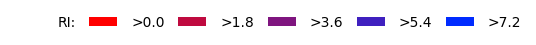

In [138]:
ligand = 'small'
print("Target")
# models = ['combinedv2_2']
# show prediction
for model in ['combinedv2_2']:
    try:
        print(model)
        ri_tensor = get_ri_tensor(prot_id, model, name=ligand)
        prot.show_structure(color='ri', ri_tensor=ri_tensor)
    except Exception as e:
        print("ERROR")
        print(e)

Target


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

combinedv2_2


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

embedding


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

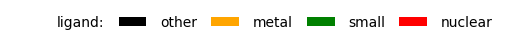

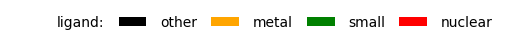

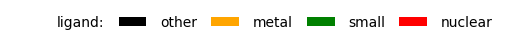

In [137]:
print("Target")
# show target
prot.show_structure(color='ligand')
# show prediction
for model in models:
    try:
        print(model)
        prot.bind_annotation.tensor = get_pred_tensor(prot_id, model)
        prot.show_structure(color='ligand', ri_tensor=ri_tensor)
    except Exception as e:
        print("ERROR")
        print(e)
        
# reset
prot.bind_annotation.tensor = target_tensor

In [141]:
# show target
print("Target")
prot.show_umap()
# show prediction
for model in models:
    try:
        print(model)
        prot.bind_annotation.tensor = get_pred_tensor(prot_id, model)
        prot.show_umap()
    except Exception as e:
        print("ERROR")
        print(e)
# reset
prot.bind_annotation.tensor = target_tensor

Target
UMAP(init='random', n_neighbors=30, random_state=42, verbose=True)
Wed Jul 20 23:57:08 2022 Construct fuzzy simplicial set
Wed Jul 20 23:57:08 2022 Finding Nearest Neighbors
Wed Jul 20 23:57:08 2022 Finished Nearest Neighbor Search
Wed Jul 20 23:57:08 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Jul 20 23:57:08 2022 Finished embedding


combinedv2_2
UMAP(init='random', n_neighbors=30, random_state=42, verbose=True)
Wed Jul 20 23:57:08 2022 Construct fuzzy simplicial set
Wed Jul 20 23:57:09 2022 Finding Nearest Neighbors
Wed Jul 20 23:57:09 2022 Finished Nearest Neighbor Search
Wed Jul 20 23:57:09 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Jul 20 23:57:10 2022 Finished embedding


embedding
UMAP(init='random', n_neighbors=30, random_state=42, verbose=True)
Wed Jul 20 23:57:10 2022 Construct fuzzy simplicial set
Wed Jul 20 23:57:10 2022 Finding Nearest Neighbors
Wed Jul 20 23:57:10 2022 Finished Nearest Neighbor Search
Wed Jul 20 23:57:10 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Jul 20 23:57:11 2022 Finished embedding
